# MNIST Digit Classification - FCN

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
import os
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

MODEL_FILE = os.path.join(DATA_DIR, "theano-mnist-fcn")

LEARNING_RATE = 0.001
REG_LAMBDA = 0.01

INPUT_SIZE = 28*28
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 10000

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append([float(x) / 255. for x in cols[1:]])
#         xdata.append([float(x) for x in cols[1:]])
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    X = np.array(xdata).astype("float32")
    y = np.array(ydata).astype("int32")
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 784) (60000,) (10000, 784) (10000,)


## Define Network

In [4]:
X = T.matrix('X')
y = T.lvector('y')

In [5]:
W1 = theano.shared(np.random.randn(INPUT_SIZE, 128), name="W1")
b1 = theano.shared(np.zeros(128), name="b1")

W2 = theano.shared(np.random.randn(128, 64), name="W2")
b2 = theano.shared(np.zeros(64), name="b2")

W3 = theano.shared(np.random.randn(64, NUM_CLASSES), name="W3")
b3 = theano.shared(np.zeros(NUM_CLASSES), name="b3")

In [6]:
# FC1: 784 => 128
z1 = X.dot(W1) + b1
a1 = T.nnet.relu(z1)
# FC2: 128 => 64
z2 = a1.dot(W2) + b2
a2 = T.nnet.relu(z2)
# FC3: 64 => 10
z3 = a2.dot(W3) + b3
y_hat = T.nnet.softmax(z3)

In [7]:
loss_reg = (REG_LAMBDA/(2*len(Xtrain))) * (T.sum(T.sqr(W1)) + 
                                           T.sum(T.sqr(W2)) +
                                           T.sum(T.sqr(W3))) 
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg
prediction = T.argmax(y_hat, axis=1)

In [8]:
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

In [9]:
# self-check on model
# forward_prop(np.random.randn(10, 784))

In [10]:
dW3 = T.grad(loss, W3)
db3 = T.grad(loss, b3)
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [11]:
gradient_step = theano.function(
    [X, y],
    updates=((W3, W3 - LEARNING_RATE * dW3),
             (W2, W2 - LEARNING_RATE * dW2),
             (W1, W1 - LEARNING_RATE * dW1),
             (b3, b3 - LEARNING_RATE * db3),
             (b2, b2 - LEARNING_RATE * db2),
             (b1, b1 - LEARNING_RATE * db1)))

## Train Network

In [12]:
history = []
num_batches = len(Xtrain) // BATCH_SIZE
for epoch in range(NUM_EPOCHS):
    shuffled_indices = np.random.permutation(np.arange(len(Xtrain)))
    total_loss, total_acc = 0., 0.
    for bid in range(num_batches - 1):
        bstart = bid * BATCH_SIZE
        bend = (bid + 1) * BATCH_SIZE
        Xbatch = [Xtrain[i] for i in shuffled_indices[bstart:bend]]
        ybatch = [ytrain[i] for i in shuffled_indices[bstart:bend]]
        gradient_step(Xbatch, ybatch)
        total_loss += calculate_loss(Xbatch, ybatch)
        break
    total_loss /= num_batches
    # validate with 10% training data
    val_indices = shuffled_indices[0:len(Xtrain)//10]
    Xval = [Xtrain[i] for i in val_indices]
    yval = [ytrain[i] for i in val_indices]
    yval_ = predict(Xval)
    total_acc = accuracy_score(yval_, yval)
    history.append((total_loss, total_acc))
    if (epoch + 1) % 1000 == 0:
        print("Epoch {:d}/{:d}: loss={:.4f}, accuracy: {:.4f}".format(
            epoch+1, NUM_EPOCHS, total_loss, total_acc))    

Epoch 1000/10000: loss=0.0471, accuracy: 0.7168
Epoch 2000/10000: loss=0.0221, accuracy: 0.7322
Epoch 3000/10000: loss=0.0106, accuracy: 0.7428
Epoch 4000/10000: loss=0.0092, accuracy: 0.7315
Epoch 5000/10000: loss=0.0091, accuracy: 0.7353
Epoch 6000/10000: loss=0.0062, accuracy: 0.7353
Epoch 7000/10000: loss=0.0036, accuracy: 0.6765
Epoch 8000/10000: loss=0.0018, accuracy: 0.7272
Epoch 9000/10000: loss=0.0025, accuracy: 0.7382
Epoch 10000/10000: loss=0.0029, accuracy: 0.6567


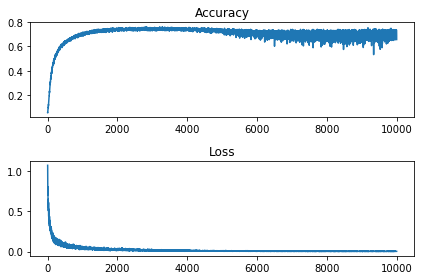

In [13]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Evaluate Network

In [14]:
ytest_ = predict(Xtest)
acc = accuracy_score(ytest_, ytest)
cm = confusion_matrix(ytest_, ytest)
print("accuracy: {:.3f}".format(acc))
print("confusion matrix")
print(cm)

accuracy: 0.656
confusion matrix
[[ 814    1   33   17    1   35   12    9   13   10]
 [   0 1065   43   10    6    3    1   28   11    6]
 [   4    3  143    6    1    2    2    1    5    1]
 [  57   23  236  835   15  260   10   87   57   24]
 [   2    1   10    3  453    7   23    5    6   13]
 [   9    3    6    8    1  291    7    4   11    2]
 [  61    5  207   17   86   69  837    2   53   25]
 [   3    2   10   11    2    4    1  486    6   17]
 [  25   26  307   80   46  190   49   34  770   42]
 [   5    6   37   23  371   31   16  372   42  869]]
